# The vertical Sato-Tate-Distribution



In [56]:
import matplotlib.pyplot as plt
import numpy as np

class Vertical_Sato_Tate():
    def __init__(self):
        self._ec_list = []
        self.n_max = 1

    def _ec_list_increment(self):
        for a in range(self.n_max + 1):
            self._ec_list.append(EllipticCurve([a,self.n_max]))
        for b in range(self.n_max):
            self._ec_list.append(EllipticCurve([self.n_max, b]))
        self.n_max += 1

    def ec_list(self, n):
        while self.n_max  < n:
            self._ec_list_increment()
        
        if n < self.n_max:
            return self._ec_list[:n^2-1]

        return self._ec_list

    def ec_list_old(self, n):
        #faster, but always returns entire list
        if n > self.n_max:
            #all new EC with a bigger then before
            for a in range(self.n_max, n):
                for b in range(n):
                    if a != 0 or b != 0:
                        self._ec_list.append(EllipticCurve([a,b]))
            #all new EC with a in same range as before
            for a in range(self.n_max):
                for b in range(self.n_max, n):
                    self._ec_list.append(EllipticCurve([a,b]))
            self.n_max = n
        
        return self._ec_list

    def ap_list(self,p):
        return [E.ap(p) for E in self.ec_list_old(p)]
    
    def normalized_aplist(self, p):
        return [RR(x/(2 * sqrt(p))) for x in self.ap_list(p)]
    
    def histogram(self, p, num_bins):
        '''
        modified with matplotlib plotting
        '''
        #original code:
        #v = self.normalized_aplist(p)
        #d, total_number_of_points = dist(v, num_bins)
        #return frequency_histogram(d, num_bins, total_number_of_points) + semicircle
        v = self.normalized_aplist(p)
        n, bins, patches = plt.hist(v, num_bins, density=True)
        angle = np.linspace(0, np.pi, 150) 
        radius = 1
        x = radius * np.cos(angle) 
        y = radius * np.sin(angle) * 2 / np.pi #stretching so that area = 1
        plt.plot(x, y)
        plt.xlabel('$a_p/\\sqrt{p}$')
        plt.ylabel('Frequency')
        plt.title('Vertical Sato-Tate-Distribution for p = {}'.format(p))
        #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
        plt.xlim(-1,1)
        #plt.ylim(0, 1)
        plt.grid(True)
        plt.show()

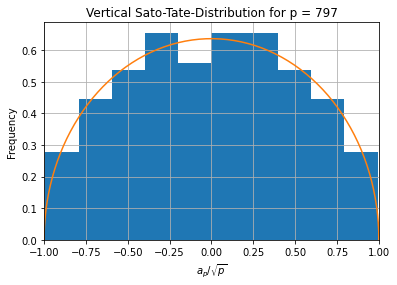

In [57]:
VST = Vertical_Sato_Tate()

VST.histogram(797, 10)


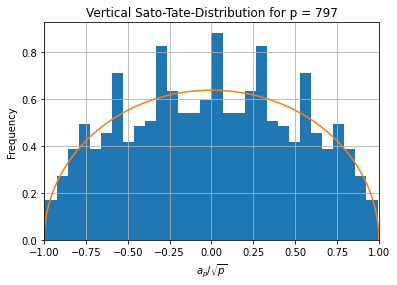

In [59]:
VST.histogram(797, 30)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import numexpr as ne

In [26]:
p = 99991
F = GF(p)
the_1728_j = F(1728)

my_simple_js = list(range(1,p))
my_simple_js.remove(the_1728_j)
my_ecs_over_F = []
for j in my_simple_js:
    E = EllipticCurve_from_j(F(j), minimal_twist=False)
    my_ecs_over_F.append(E)
    Etwist = E.quadratic_twist()
    my_ecs_over_F.append(Etwist)



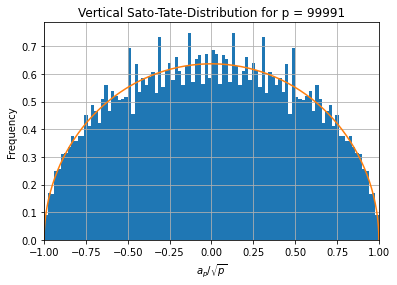

In [45]:
ap_list = np.array([E.cardinality() for E in my_ecs_over_F])
v = (ap_list - p-1)/float(2 * math.sqrt(p))

n, bins, patches = plt.hist(v, num_bins, density=True)
angle = np.linspace(0, np.pi, 150) 
radius = 1
x = radius * np.cos(angle) 
y = radius * np.sin(angle) * 2 / np.pi #stretching so that area = 1
plt.plot(x, y)
plt.xlabel('$a_p/\\sqrt{p}$')
plt.ylabel('Frequency')
plt.title('Vertical Sato-Tate-Distribution for p = {}'.format(p))
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-1,1)
#plt.ylim(0, 1)
plt.grid(True)
plt.show()